Cargando y procesando datos...
Matriz de transición creada con 14 estados

Probando con 100000 iteraciones...
Tiempo de ejecución: 363.00 segundos
Probabilidad de conversión: 0.701120
Canales con atribución > 0: 12 de 12

Probando con 150000 iteraciones...
Tiempo de ejecución: 556.17 segundos
Probabilidad de conversión: 0.703520
Canales con atribución > 0: 12 de 12

Probando con 175000 iteraciones...
Tiempo de ejecución: 645.96 segundos
Probabilidad de conversión: 0.704200
Canales con atribución > 0: 12 de 12

Probando con 200000 iteraciones...
Tiempo de ejecución: 732.03 segundos
Probabilidad de conversión: 0.703335
Canales con atribución > 0: 12 de 12

Probando con 225000 iteraciones...
Tiempo de ejecución: 824.44 segundos
Probabilidad de conversión: 0.701716
Canales con atribución > 0: 12 de 12

Diferencia promedio en top 10 canales entre 100000 y 150000 iteraciones: 31.56%

Diferencia promedio en top 10 canales entre 150000 y 175000 iteraciones: 14.75%

Diferencia promedio en top 1

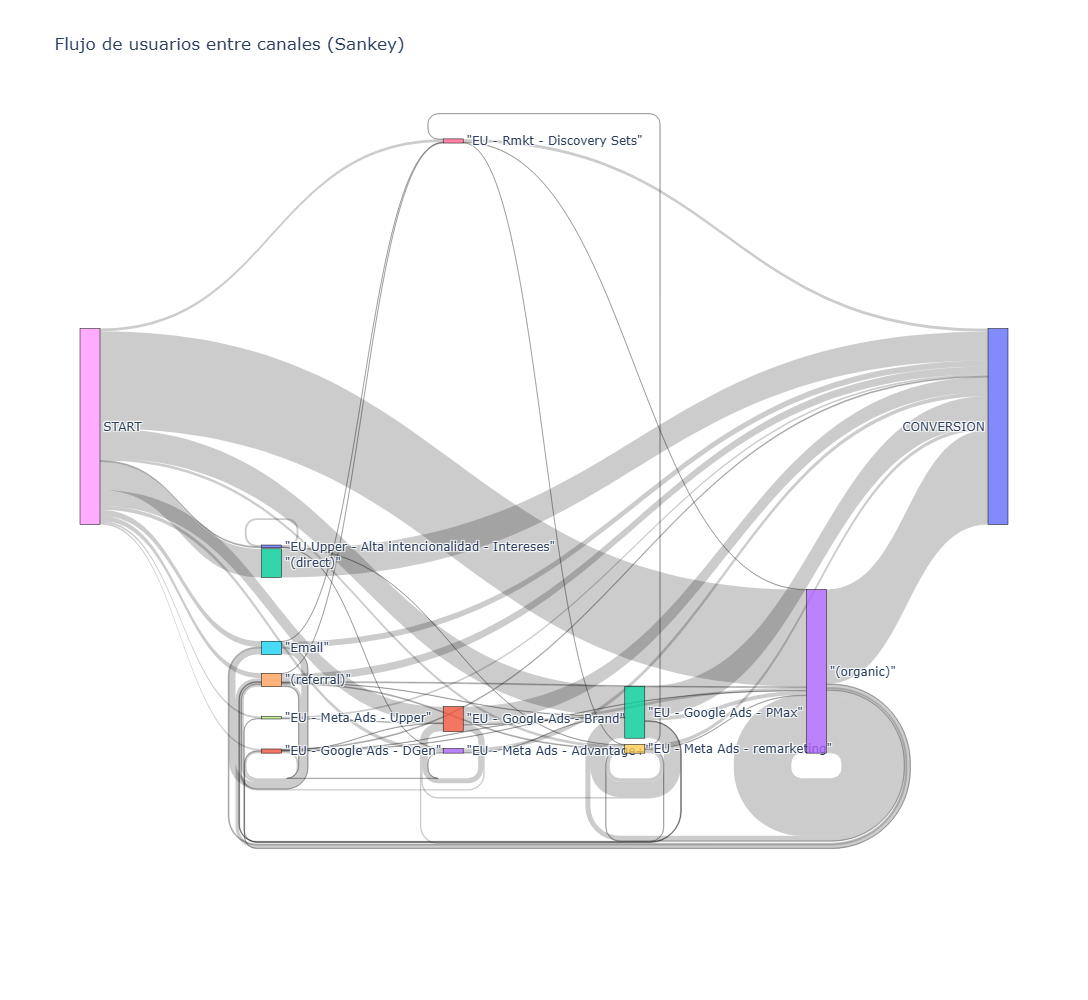

✅ Gráfico 'comparacion_iteraciones.png' guardado correctamente.
✅ Archivo 'comparacion_atribucion.csv' guardado correctamente.
✅ Archivo 'atribucion_completa_100000_iter.csv' guardado correctamente.
✅ Archivo 'atribucion_completa_150000_iter.csv' guardado correctamente.
✅ Archivo 'atribucion_completa_175000_iter.csv' guardado correctamente.
✅ Archivo 'atribucion_completa_200000_iter.csv' guardado correctamente.
✅ Archivo 'atribucion_completa_225000_iter.csv' guardado correctamente.

=== CONCLUSIONES ===
Diferencia promedio entre 100000 y 225000 iteraciones: 28.18%
❌ Se recomienda usar al menos 225000 iteraciones (diferencia > 10%)

Las métricas sugeridas para decidir el número óptimo de iteraciones son:
1. Estabilidad en los valores de atribución de los principales canales
2. Número de canales con atribución no nula
3. Tiempo de computación aceptable

✅ Análisis completado. Revisa los archivos generados para tomar una decisión informada.


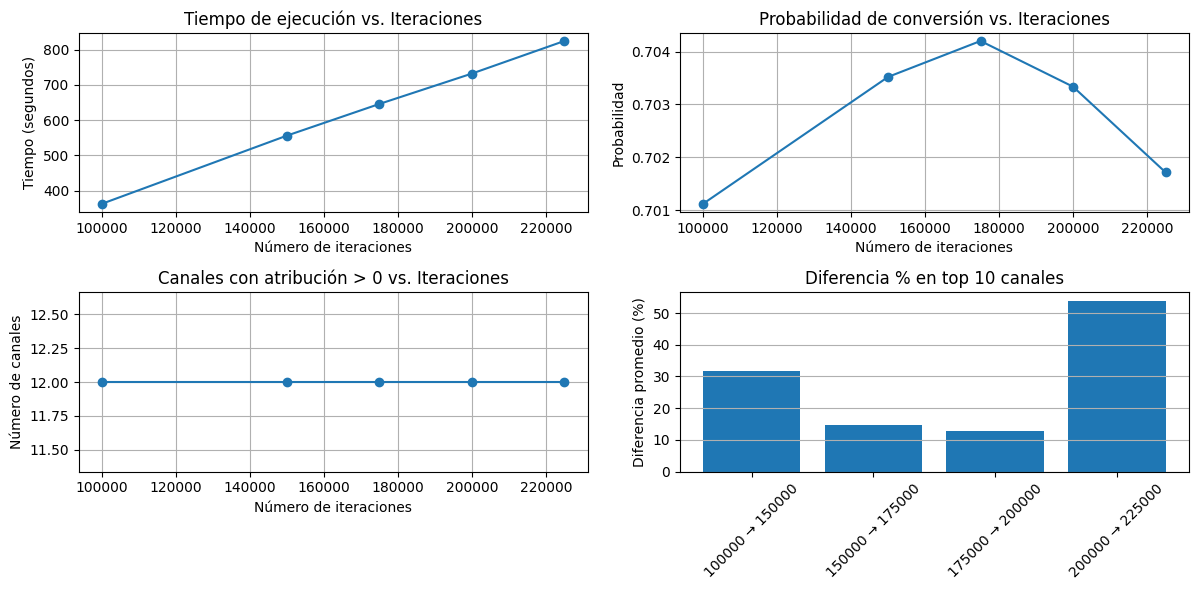

In [9]:
import pandas as pd
import numpy as np
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# -------------------------------
# CONFIGURACIÓN
# -------------------------------

# Fijar la semilla para reproducibilidad
np.random.seed(42)

# Iteraciones a probar
ITERATIONS_TO_TEST = [100000, 150000, 175000, 200000, 225000]

# Variables globales para almacenar los resultados de atribución
removal_attribution_global = {}
first_touch_attribution_global = {}

# Umbral mínimo de atribución
MIN_ATTRIBUTION = 0.001

# Método de atribución
ATTRIBUTION_METHOD = 'balanced'

# Ruta del archivo CSV con rutas y conversiones  
ruta_csv = "rutas.csv"  # Ajusta esta ruta a la ubicación del archivo en tu sistema

# Separador entre canales
separator = ' > '

# -------------------------------
# FUNCIONES
# -------------------------------

def load_and_process_data(csv_path, separator):
    """Carga y procesa los datos de rutas"""
    data = pd.read_csv(csv_path)

    # Verificar columnas necesarias
    if 'path' not in data.columns or 'conversions' not in data.columns:
        raise ValueError("El CSV debe contener las columnas 'path' y 'conversions'")

    # Contar apariciones y transiciones
    channel_counts = defaultdict(int)
    transition_counts = defaultdict(int)

    for _, row in data.iterrows():
        steps = row['path'].split(separator)
        steps = ['START'] + steps + ['CONVERSION']

        # Contar apariciones
        for step in steps:
            if step not in ['START', 'CONVERSION']:
                channel_counts[step] += row['conversions']

        # Contar transiciones
        for i in range(len(steps) - 1):
            transition_counts[(steps[i], steps[i+1])] += row['conversions']

    # Crear matriz de transición
    states = list(set([k[0] for k in transition_counts] + [k[1] for k in transition_counts]))
    transition_matrix = pd.DataFrame(0.0, index=states, columns=states)

    for (from_state, to_state), count in transition_counts.items():
        total_from = sum([v for (f, t), v in transition_counts.items() if f == from_state])
        if total_from > 0:
            transition_matrix.loc[from_state, to_state] = count / total_from

    return transition_matrix, channel_counts, transition_counts

def simulate_conversion_prob(matrix, start_state, n_simulations):
    """Simula la probabilidad de conversión usando la matriz de transición"""
    conversions = 0
    path_channels = set()

    for _ in range(n_simulations):
        state = start_state
        steps = 0
        MAX_STEPS = 100

        while steps < MAX_STEPS:
            probs = matrix.loc[state].values
            total_prob = probs.sum()

            if total_prob < 1e-10:
                break

            probs = probs / total_prob

            try:
                next_state = np.random.choice(matrix.columns, p=probs)
            except ValueError:
                break

            if next_state != 'START' and next_state != 'CONVERSION':
                path_channels.add(next_state)

            if next_state == 'CONVERSION':
                conversions += 1
                break
            elif next_state == state or next_state == 'NULL':
                break
            else:
                state = next_state
                steps += 1

    return conversions / n_simulations, path_channels

def calculate_attribution(transition_matrix, n_simulations, method='balanced', min_attribution=0.001):
    """Calcula la atribución de cada canal según el método elegido"""
    start_time = time.time()

    # Simular probabilidad original
    original_prob, channels_in_paths = simulate_conversion_prob(transition_matrix, 'START', n_simulations)

    # Calcular efectos
    removal_effect = {}
    first_touch_effect = {}

    # Para cada canal, calcular su efecto
    for channel in set(transition_matrix.columns) - {'START', 'CONVERSION', 'NULL'}:
        # 1. Método de removal effect
        matrix_copy = transition_matrix.copy()
        matrix_copy.loc[:, channel] = 0
        matrix_copy.loc[channel, :] = 0

        prob_without, _ = simulate_conversion_prob(matrix_copy, 'START', n_simulations)
        removal_effect[channel] = max(original_prob - prob_without, 0)

        # 2. Método de first-touch
        first_touch_count = transition_counts.get(('START', channel), 0)
        total_first_touches = sum([v for (f, t), v in transition_counts.items() if f == 'START'])

        if total_first_touches > 0:
            first_touch_effect[channel] = first_touch_count / total_first_touches
        else:
            first_touch_effect[channel] = 0

    # Normalización
    total_removal = sum(removal_effect.values())
    if total_removal > 0:
        removal_attribution = {k: v / total_removal for k, v in removal_effect.items()}
    else:
        removal_attribution = {k: 0 for k in removal_effect}

    total_first_touch = sum(first_touch_effect.values())
    if total_first_touch > 0:
        first_touch_attribution = {k: v / total_first_touch for k, v in first_touch_effect.items()}
    else:
        first_touch_attribution = {k: 0 for k in first_touch_effect}

    # Elegir método final
    if method == 'removal_effect':
        attribution = removal_attribution
    elif method == 'first_touch_bias':
        attribution = first_touch_attribution
    elif method == 'balanced':
        # Combinar ambos métodos (60% removal, 40% first-touch)
        attribution = {}
        for channel in set(removal_attribution.keys()) | set(first_touch_attribution.keys()):
            removal_value = removal_attribution.get(channel, 0)
            first_touch_value = first_touch_attribution.get(channel, 0)
            attribution[channel] = 0.6 * removal_value + 0.4 * first_touch_value

    # Aplicar umbral mínimo
    for channel in attribution:
        if attribution[channel] < min_attribution and channel_counts[channel] > 0:
            attribution[channel] = min_attribution

    # Renormalizar
    total_attr = sum(attribution.values())
    attribution = {k: v / total_attr for k, v in attribution.items()}

    end_time = time.time()
    execution_time = end_time - start_time

    # Guardar los valores de atribución original para uso posterior
    global removal_attribution_global, first_touch_attribution_global
    removal_attribution_global = removal_attribution
    first_touch_attribution_global = first_touch_attribution

    return attribution, original_prob, execution_time

# -------------------------------
# EXPERIMENTO PRINCIPAL
# -------------------------------

print("Cargando y procesando datos...")
transition_matrix, channel_counts, transition_counts = load_and_process_data(ruta_csv, separator)
print(f"Matriz de transición creada con {len(transition_matrix.columns)} estados")

# Almacenar resultados para cada número de iteraciones
all_results = {}
execution_times = []
conversion_probs = []
nonzero_channels = []

# Comprobar consistencia con diferentes números de iteraciones
for n_iter in ITERATIONS_TO_TEST:
    print(f"\nProbando con {n_iter} iteraciones...")
    attribution, conv_prob, exec_time = calculate_attribution(
        transition_matrix,
        n_iter,
        method=ATTRIBUTION_METHOD,
        min_attribution=MIN_ATTRIBUTION
    )

    all_results[n_iter] = attribution
    execution_times.append(exec_time)
    conversion_probs.append(conv_prob)
    nonzero_channels.append(len([ch for ch, val in attribution.items() if val > 0]))

    print(f"Tiempo de ejecución: {exec_time:.2f} segundos")
    print(f"Probabilidad de conversión: {conv_prob:.6f}")
    print(f"Canales con atribución > 0: {nonzero_channels[-1]} de {len(attribution)}")

# Calcular diferencias entre ejecuciones consecutivas
differences = []
for i in range(1, len(ITERATIONS_TO_TEST)):
    prev_iter = ITERATIONS_TO_TEST[i-1]
    curr_iter = ITERATIONS_TO_TEST[i]

    # Seleccionar top 10 canales según la mayor iteración
    top_channels = sorted(all_results[curr_iter].items(), key=lambda x: x[1], reverse=True)[:10]
    top_channel_names = [ch for ch, _ in top_channels]

    # Calcular diferencia promedio para estos canales
    diffs = []
    for channel in top_channel_names:
        prev_value = all_results[prev_iter].get(channel, 0)
        curr_value = all_results[curr_iter].get(channel, 0)
        if curr_value > 0:  # Evitar división por cero
            pct_diff = abs(curr_value - prev_value) / curr_value * 100
            diffs.append(pct_diff)

    avg_diff = sum(diffs) / len(diffs) if diffs else 0
    differences.append(avg_diff)

    print(f"\nDiferencia promedio en top 10 canales entre {prev_iter} y {curr_iter} iteraciones: {avg_diff:.2f}%")

# -------------------------------
# VISUALIZACIÓN DE RESULTADOS
# -------------------------------

# -------------------------------
# VISUALIZACIÓN – SANKEY MEJORADO
# -------------------------------

# Crear el diagrama Sankey
labels = list(set([k[0] for k in transition_counts] + [k[1] for k in transition_counts]))
label_indices = {label: i for i, label in enumerate(labels)}

sources = [label_indices[k[0]] for k in transition_counts.keys()]
targets = [label_indices[k[1]] for k in transition_counts.keys()]
values = list(transition_counts.values())

# Verificar que tenemos datos válidos
if not sources or not targets or not values:
    print("⚠️ No hay suficientes datos para generar el diagrama Sankey")
else:
    try:
        fig = go.Figure(data=[go.Sankey(
            node=dict(
                pad=30,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=labels,
            ),
            link=dict(
                source=sources,
                target=targets,
                value=values
            ))])

        fig.update_layout(
            title_text="Flujo de usuarios entre canales (Sankey)",
            font_size=12,
            height=1000,  # Altura explícita
            width=1800   # Anchura explícita
        )

        # Guardar como HTML
        fig.write_html("sankey_markov.html")
        print("✅ Archivo 'sankey_markov.html' guardado correctamente.")

        # En Jupyter, esto mostrará el gráfico directamente
        fig.show()

    except Exception as e:
        print(f"❌ Error al crear el diagrama Sankey: {e}")
        print("   Verifica que los datos de transición son válidos.")

# 1. Gráfico de tiempos de ejecución
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(ITERATIONS_TO_TEST, execution_times, 'o-')
plt.title('Tiempo de ejecución vs. Iteraciones')
plt.xlabel('Número de iteraciones')
plt.ylabel('Tiempo (segundos)')
plt.grid(True)

# 2. Gráfico de probabilidad de conversión
plt.subplot(2, 2, 2)
plt.plot(ITERATIONS_TO_TEST, conversion_probs, 'o-')
plt.title('Probabilidad de conversión vs. Iteraciones')
plt.xlabel('Número de iteraciones')
plt.ylabel('Probabilidad')
plt.grid(True)

# 3. Gráfico de canales con atribución no nula
plt.subplot(2, 2, 3)
plt.plot(ITERATIONS_TO_TEST, nonzero_channels, 'o-')
plt.title('Canales con atribución > 0 vs. Iteraciones')
plt.xlabel('Número de iteraciones')
plt.ylabel('Número de canales')
plt.grid(True)

# 4. Gráfico de diferencias porcentuales
if differences:
    plt.subplot(2, 2, 4)
    iter_pairs = [f"{ITERATIONS_TO_TEST[i-1]} → {ITERATIONS_TO_TEST[i]}" for i in range(1, len(ITERATIONS_TO_TEST))]
    plt.bar(iter_pairs, differences)
    plt.title('Diferencia % en top 10 canales')
    plt.ylabel('Diferencia promedio (%)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

plt.tight_layout()
plt.savefig('comparacion_iteraciones.png')
print("✅ Gráfico 'comparacion_iteraciones.png' guardado correctamente.")

# Crear tabla comparativa de los top 10 canales
final_results = all_results[ITERATIONS_TO_TEST[-1]]
top_channels = sorted(final_results.items(), key=lambda x: x[1], reverse=True)[:10]

comparison_data = []
headers = ['Canal'] + [f'{n_iter} iter.' for n_iter in ITERATIONS_TO_TEST] + ['Máx. diferencia %']

for channel, _ in top_channels:
    row = [channel]
    values = [all_results[n_iter].get(channel, 0) for n_iter in ITERATIONS_TO_TEST]
    row.extend([f"{val:.6f}" for val in values])

    # Calcular diferencia máxima
    if len(values) > 1 and values[-1] > 0:  # Comparar con el valor final como referencia
        max_diff = max([abs(val - values[-1]) / values[-1] * 100 for val in values[:-1]] or [0])
        row.append(f"{max_diff:.2f}")
    else:
        row.append("N/A")

    comparison_data.append(row)

# Crear DataFrame y guardar como CSV
comparison_df = pd.DataFrame(comparison_data, columns=headers)
comparison_df.to_csv('comparacion_atribucion.csv', index=False)
print("✅ Archivo 'comparacion_atribucion.csv' guardado correctamente.")

# Generar y guardar el archivo completo de atribución para cada número de iteraciones
for n_iter in ITERATIONS_TO_TEST:
    # Obtener resultados de esta iteración
    attribution = all_results[n_iter]

    # Crear DataFrame con todos los canales y sus métricas
    full_results = []
    for channel in attribution.keys():
        # Obtener valores de los diferentes métodos de atribución para esta iteración
        removal_value = removal_attribution_global.get(channel, 0)
        first_touch_value = first_touch_attribution_global.get(channel, 0)

        full_results.append({
            'channel': channel,
            'attribution': attribution.get(channel, 0),
            'apariciones': channel_counts.get(channel, 0),
            'removal_effect': removal_value,
            'first_touch': first_touch_value
        })

    # Crear y guardar DataFrame
    full_df = pd.DataFrame(full_results)
    full_df = full_df.sort_values(by='attribution', ascending=False)
    filename = f'atribucion_completa_{n_iter}_iter.csv'
    full_df.to_csv(filename, index=False)
    print(f"✅ Archivo '{filename}' guardado correctamente.")

# Resumen de conclusiones
print("\n=== CONCLUSIONES ===")
print(f"Diferencia promedio entre {ITERATIONS_TO_TEST[0]} y {ITERATIONS_TO_TEST[-1]} iteraciones: {sum(differences)/len(differences):.2f}%")

if sum(differences)/len(differences) < 5:
    print(f"✅ {ITERATIONS_TO_TEST[0]} iteraciones parecen suficientes (diferencia < 5%)")
elif sum(differences)/len(differences) < 10:
    print(f"⚠️ {ITERATIONS_TO_TEST[0]} iteraciones muestran variación moderada (diferencia < 10%)")
else:
    print(f"❌ Se recomienda usar al menos {ITERATIONS_TO_TEST[-1]} iteraciones (diferencia > 10%)")

print("\nLas métricas sugeridas para decidir el número óptimo de iteraciones son:")
print("1. Estabilidad en los valores de atribución de los principales canales")
print("2. Número de canales con atribución no nula")
print("3. Tiempo de computación aceptable")

print("\n✅ Análisis completado. Revisa los archivos generados para tomar una decisión informada.")